HW 5!

I worked with Emma Brown on this homework assignment! 

Download the voice features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import seaborn as sns
from scipy import stats
import os

import skmob
from skmob.measures.individual import jump_lengths
from skmob.tessellation import tilers
from skmob.preprocessing import detection, clustering
from skmob.preprocessing import filtering
from skmob.preprocessing import compression

In [2]:
data_dir = '/Users/katielark/Downloads/'
voice_clip_meta_data = pd.read_csv("voice_clip_meta_data.csv")
voice_feature = pd.read_csv(data_dir+"voice_feature_20241022.csv")

Run clustering on the voice clips, using only the voice features, do not include the demographic features of the clips

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df

Using the elbow method to find the most suitable k for k-means clustering

In [4]:
list(voice_feature)
#checking columns

['f0_mean',
 'f0_std',
 'f0_var',
 'f0_min',
 'f0_max',
 'f0_skew',
 'f0_kurtosis',
 'zcr_mean',
 'zcr_std',
 'zcr_var',
 'zcr_min',
 'zcr_max',
 'zcr_skew',
 'zcr_kurtosis',
 'mfcc_00',
 'mfcc_01',
 'mfcc_02',
 'mfcc_03',
 'mfcc_04',
 'mfcc_05',
 'mfcc_06',
 'mfcc_07',
 'mfcc_08',
 'mfcc_09',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'mfcc_14',
 'mfcc_15',
 'mfcc_16',
 'mfcc_17',
 'mfcc_18',
 'mfcc_19',
 'mfcc_20',
 'mfcc_21',
 'mfcc_22',
 'mfcc_23',
 'mfcc_24',
 'client_id',
 'path',
 'sentence_id',
 'sentence',
 'up_votes',
 'down_votes',
 'age',
 'gender',
 'accents',
 'len_in_second',
 'sampling_rate',
 'array_size']

In [5]:
voice_feature = voice_feature.dropna(subset=['f0_mean', 'f0_skew'])
#eliminating nan values from relevant columns

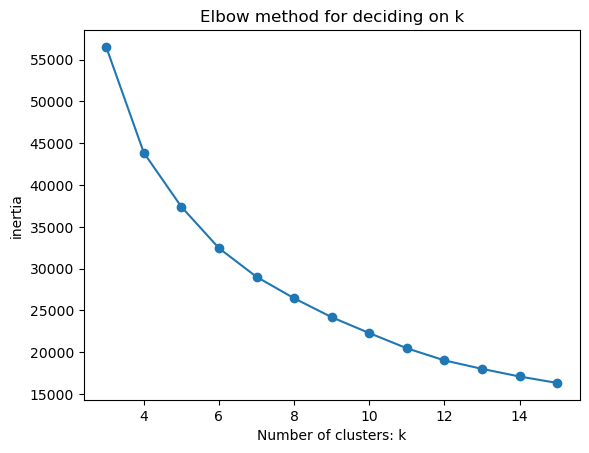

In [6]:
df = voice_feature
colnames = ["f0_mean", "f0_std","f0_var", "f0_min", "f0_max", "f0_skew", "f0_kurtosis"]
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)
#looking at f0

In [7]:
k = 4
#4 clusters seems right based on elbow method
colnames = ["f0_mean", "f0_std","f0_var", "f0_min", "f0_max", "f0_skew", "f0_kurtosis"]
f0_kmeans = run_kmeans(df, colnames,k,)
f0_kmeans.groupby("cluster").size()
#not very even cluster sizes

cluster
0    11998
1     3668
2      172
3      856
dtype: int64

In [8]:
cluster_summary = f0_kmeans.groupby('cluster').agg(
    mean_avg=('f0_mean', 'mean'),
    std_avg=('f0_std', 'mean')
).reset_index()
#looking at descriptive stats for each cluster

In [9]:
cluster_summary

,cluster,mean_avg,std_avg
0,0,119.700388,23.110988
1,1,200.161694,38.804695
2,2,143.308464,54.027602
3,3,230.043675,177.357450


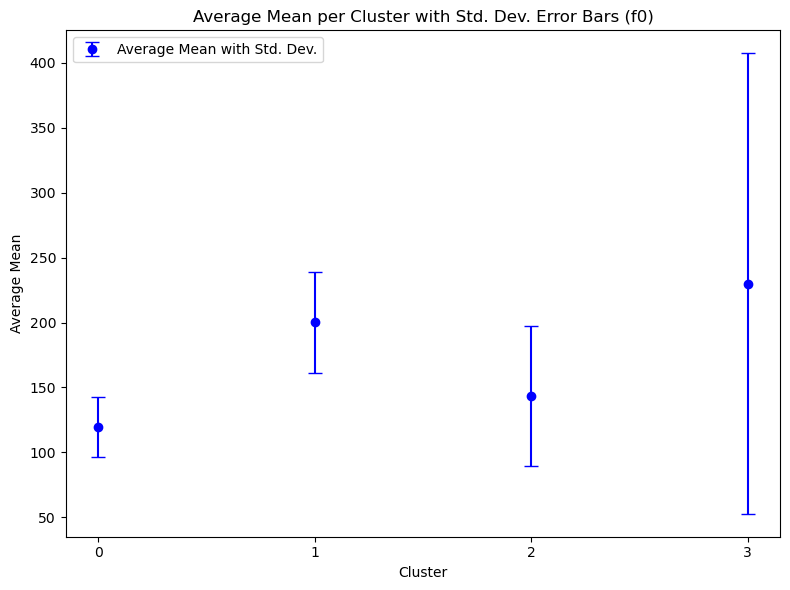

In [10]:
plt.figure(figsize=(8, 6))
plt.errorbar(cluster_summary['cluster'], 
             cluster_summary['mean_avg'], 
             yerr=cluster_summary['std_avg'], 
             fmt='o', 
             color='b', 
             capsize=5, 
             linestyle='None', 
             label='Average Mean with Std. Dev.')
plt.xlabel('Cluster')
plt.ylabel('Average Mean')
plt.title('Average Mean per Cluster with Std. Dev. Error Bars (f0)')
plt.xticks(cluster_summary['cluster'])
plt.legend()
plt.tight_layout()
#plotting descriptive stats for each cluster
#chatgpt helped with crafting the code for this plot

<Axes: xlabel='f0_mean', ylabel='f0_std'>

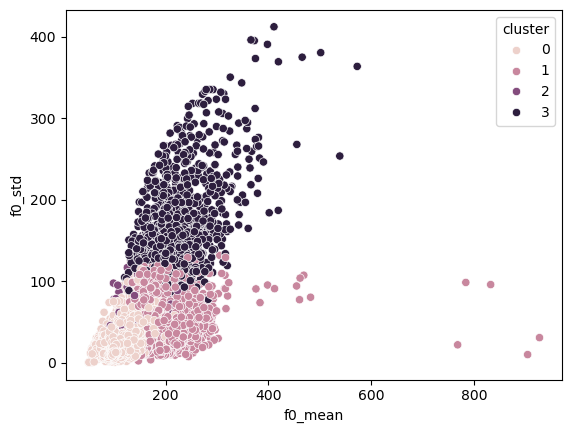

In [11]:
sns.scatterplot(f0_kmeans, x="f0_mean", y="f0_std",hue= "cluster")
#plotting scatterplot of clusters

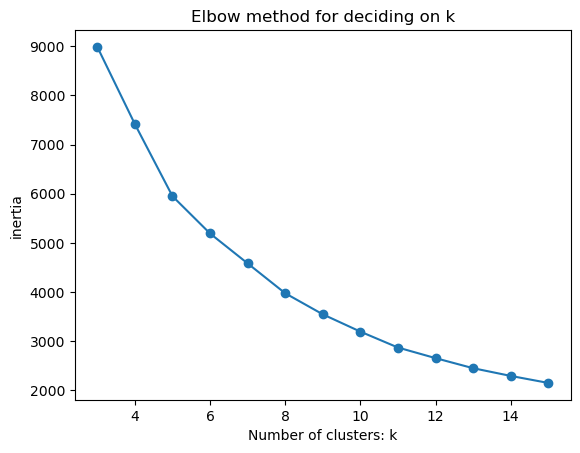

In [12]:
df = voice_feature
colnames = ["f0_mean", "f0_std"]
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)
#rerunning the code above and clustering based only off of two characteristics

In [13]:
k = 5
colnames = ["f0_mean", "f0_std"]
f0_kmeans2 = run_kmeans(df, colnames,k,)
f0_kmeans2.groupby("cluster").size()
#5 seems to be optimal cluster count
#again, not very even cluster sizes but arguably better than before

cluster
0    8749
1     367
2    2790
3     729
4    4059
dtype: int64

In [14]:
cluster_summary = f0_kmeans2.groupby('cluster').agg(
    mean_avg=('f0_mean', 'mean'),
    std_avg=('f0_std', 'mean')
).reset_index()
#pulling descriptive statistics for the clusters
#means closer/in the 200s

In [15]:
cluster_summary

,cluster,mean_avg,std_avg
0,0,108.105487,18.506783
1,1,273.408781,225.760664
2,2,211.881825,38.330273
3,3,203.142087,127.590249
4,4,149.427933,33.507568


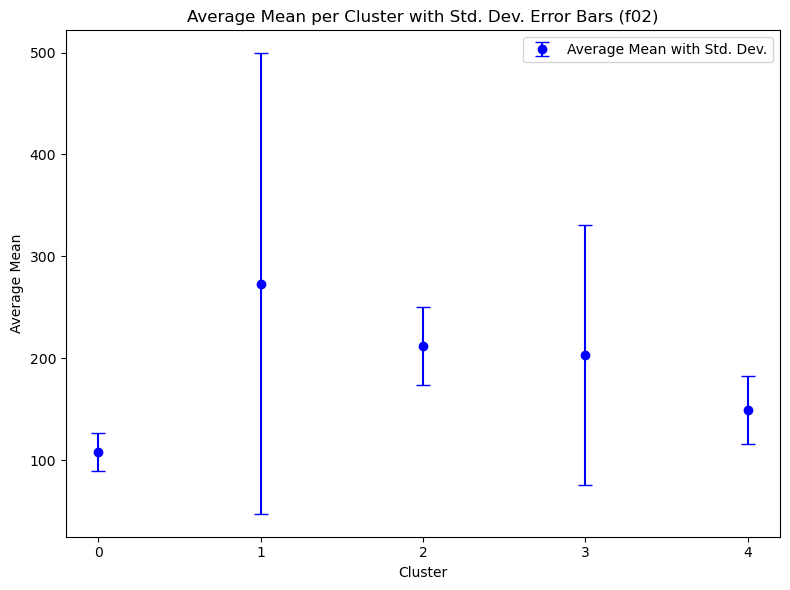

In [16]:
plt.figure(figsize=(8, 6))
plt.errorbar(cluster_summary['cluster'], 
             cluster_summary['mean_avg'], 
             yerr=cluster_summary['std_avg'], 
             fmt='o', 
             color='b', 
             capsize=5, 
             linestyle='None', 
             label='Average Mean with Std. Dev.')
plt.xlabel('Cluster')
plt.ylabel('Average Mean')
plt.title('Average Mean per Cluster with Std. Dev. Error Bars (f02)')
plt.xticks(cluster_summary['cluster'])
plt.legend()
plt.tight_layout()
#plotting descriptive statistics

<Axes: xlabel='f0_mean', ylabel='f0_std'>

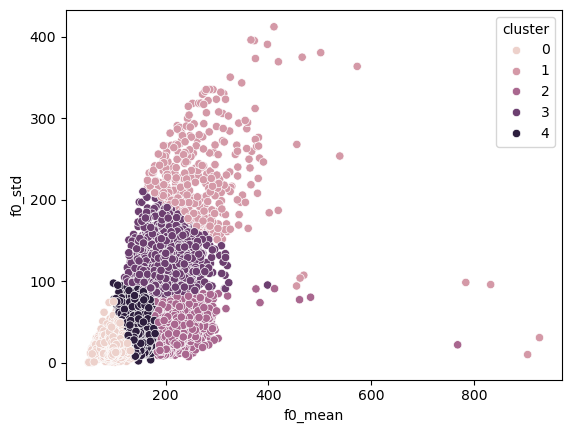

In [17]:
sns.scatterplot(f0_kmeans2, x="f0_mean", y="f0_std",hue= "cluster")
#WOW supper separated! So cool!

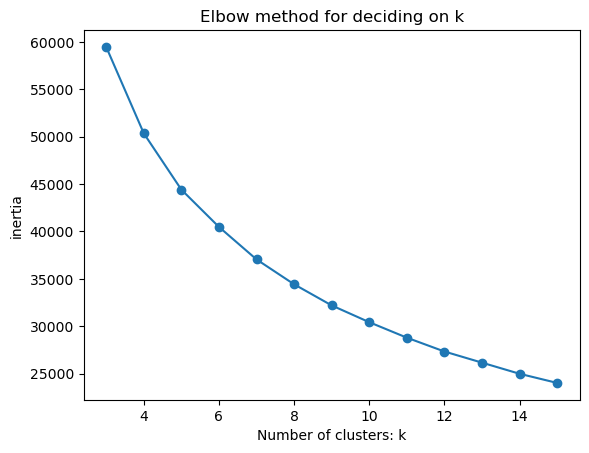

In [18]:
df = voice_feature
colnames = ['zcr_mean',
 'zcr_std',
 'zcr_var',
 'zcr_min',
 'zcr_max',
 'zcr_skew',
 'zcr_kurtosis',]
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)
#performing on zcr features

In [19]:
k = 4
#4 seems right based on elbow method
colnames = ['zcr_mean',
 'zcr_std',
 'zcr_var',
 'zcr_min',
 'zcr_max',
 'zcr_skew',
 'zcr_kurtosis',]
zcr_kmeans = run_kmeans(df, colnames,k,)
zcr_kmeans.groupby("cluster").size()
#more even cluster sizes

cluster
0    3027
1    6407
2    2352
3    4908
dtype: int64

In [20]:
cluster_summary = zcr_kmeans.groupby('cluster').agg(
    mean_avg=('zcr_mean', 'mean'),
    std_avg=('zcr_std', 'mean')
).reset_index()

In [21]:
cluster_summary

,cluster,mean_avg,std_avg
0,0,0.054153,0.058821
1,1,0.103815,0.092687
2,2,0.149484,0.126896
3,3,0.072629,0.062564


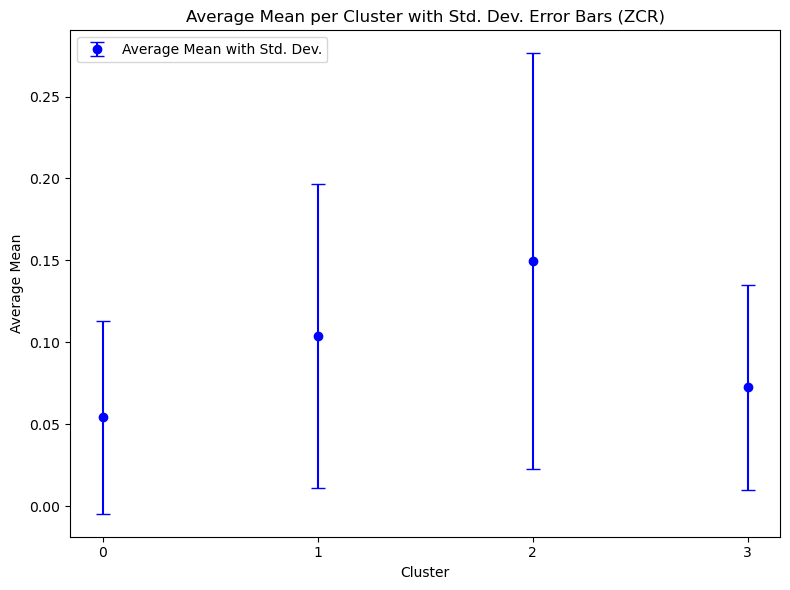

In [22]:
plt.figure(figsize=(8, 6))
plt.errorbar(cluster_summary['cluster'], 
             cluster_summary['mean_avg'], 
             yerr=cluster_summary['std_avg'], 
             fmt='o', 
             color='b', 
             capsize=5, 
             linestyle='None', 
             label='Average Mean with Std. Dev.')
plt.xlabel('Cluster')
plt.ylabel('Average Mean')
plt.title('Average Mean per Cluster with Std. Dev. Error Bars (ZCR)')
plt.xticks(cluster_summary['cluster'])
plt.legend()
plt.tight_layout()

<Axes: xlabel='zcr_mean', ylabel='zcr_std'>

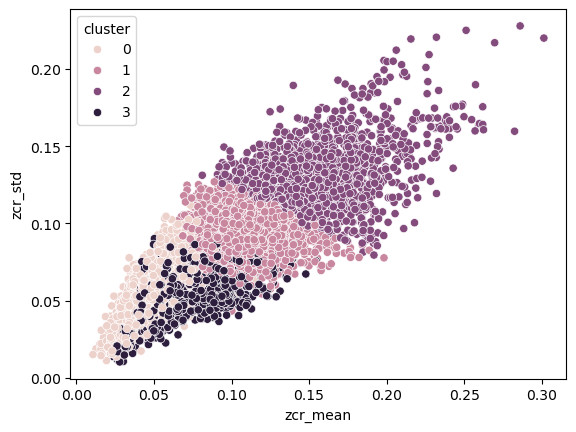

In [23]:
sns.scatterplot(zcr_kmeans, x="zcr_mean", y="zcr_std",hue= "cluster")
#WOW also pretty distinct, but not as much as the previous two. Defi

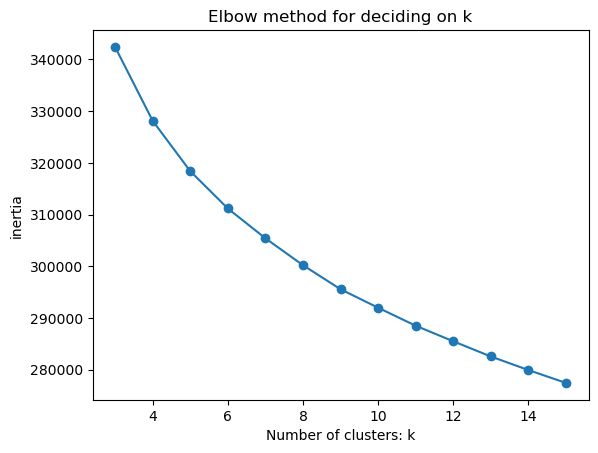

In [24]:
df = voice_feature
colnames = ['mfcc_00',
 'mfcc_01',
 'mfcc_02',
 'mfcc_03',
 'mfcc_04',
 'mfcc_05',
 'mfcc_06',
 'mfcc_07',
 'mfcc_08',
 'mfcc_09',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'mfcc_14',
 'mfcc_15',
 'mfcc_16',
 'mfcc_17',
 'mfcc_18',
 'mfcc_19',
 'mfcc_20',
 'mfcc_21',
 'mfcc_22',
 'mfcc_23',
 'mfcc_24']
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)
#performing on mfcc... not super sure what these features represent

In [25]:
k = 4
#4 seems to be the best number based on elbow method
colnames = ['mfcc_00',
 'mfcc_01',
 'mfcc_02',
 'mfcc_03',
 'mfcc_04',
 'mfcc_05',
 'mfcc_06',
 'mfcc_07',
 'mfcc_08',
 'mfcc_09',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'mfcc_14',
 'mfcc_15',
 'mfcc_16',
 'mfcc_17',
 'mfcc_18',
 'mfcc_19',
 'mfcc_20',
 'mfcc_21',
 'mfcc_22',
 'mfcc_23',
 'mfcc_24']
mfcc_kmeans = run_kmeans(df, colnames,k,)
mfcc_kmeans.groupby("cluster").size()
#more evenly distributed cluster sizes

cluster
0    3030
1    4224
2    3880
3    5560
dtype: int64